In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings("ignore")



In [2]:
df=pd.read_csv("Month_Value_1 - Month_Value_1.csv")
df.head(5)

,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,16010072.12,12729.0,1257.763541,30024676.0
1,01.02.2015,15807587.45,11636.0,1358.507000,30024676.0
2,01.03.2015,22047146.02,15922.0,1384.697024,30024676.0
3,01.04.2015,18814583.29,15227.0,1235.606705,30024676.0
4,01.05.2015,14021479.61,8620.0,1626.621765,30024676.0


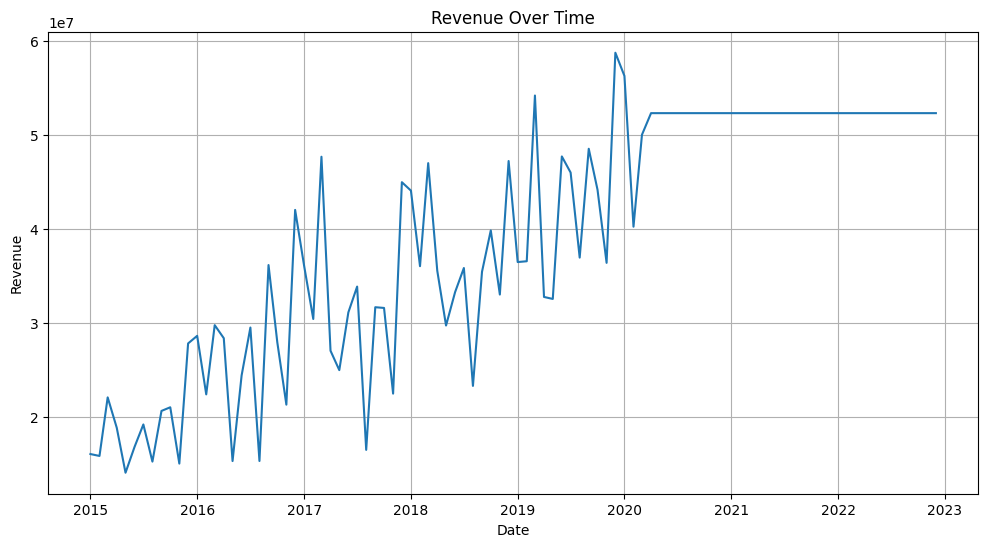

In [3]:
# Convert 'Period' to datetime and set as index
df['Period'] = pd.to_datetime(df['Period'], format='%d.%m.%Y')
df.set_index('Period', inplace=True)
df = df.sort_index()

# Interpolate missing values
df['Revenue'] = df['Revenue'].interpolate(method='time')

# Plot Revenue over time
plt.figure(figsize=(12, 6))
sns.lineplot(x=df.index, y=df['Revenue'])
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()


In [5]:

# ADF Test for stationarity
def adf_test(series):
    result = adfuller(series)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value}")
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is NOT stationary.")

print("ADF Test on Original Data")
adf_test(df['Revenue'])



ADF Test on Original Data
ADF Statistic: -1.7068549872997714
p-value: 0.42758408714588625
Critical Values:
   1%: -3.5117123057187376
   5%: -2.8970475206326833
   10%: -2.5857126912469153
The series is NOT stationary.


In [6]:
# Differencing to make data stationary
df['Revenue_diff'] = df['Revenue'].diff()
df = df.dropna()

print("\nADF Test on Differenced Data")
adf_test(df['Revenue_diff'])




ADF Test on Differenced Data
ADF Statistic: -5.604330112909441
p-value: 1.2441377990599668e-06
Critical Values:
   1%: -3.562878534649522
   5%: -2.918973284023669
   10%: -2.597393446745562
The series is stationary.


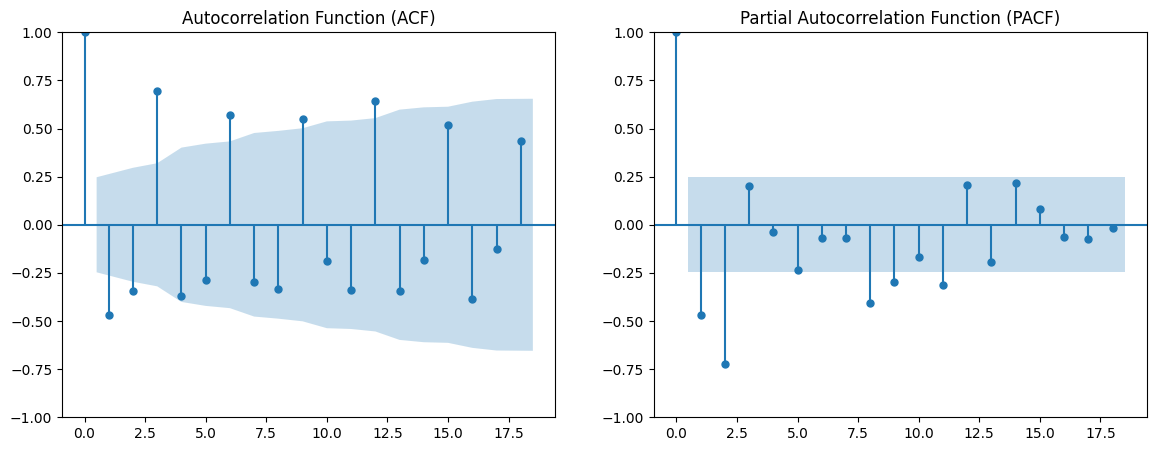

In [7]:
# ACF and PACF plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(df['Revenue_diff'], ax=ax[0])
ax[0].set_title("Autocorrelation Function (ACF)")
plot_pacf(df['Revenue_diff'], ax=ax[1])
ax[1].set_title("Partial Autocorrelation Function (PACF)")
plt.show()



                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                   63
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1062.685
Date:                Fri, 14 Mar 2025   AIC                           2133.370
Time:                        18:19:31   BIC                           2141.878
Sample:                    02-01-2015   HQIC                          2136.710
                         - 04-01-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8906      0.090     -9.932      0.000      -1.066      -0.715
ar.L2         -0.7525      0.076     -9.943      0.000      -0.901      -0.604
ma.L1          0.2569      0.149      1.720      0.0

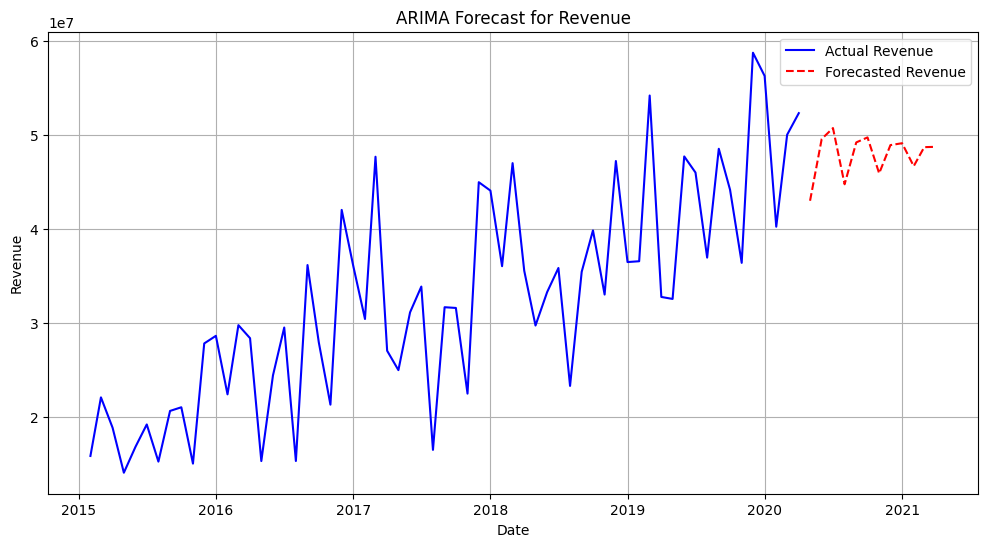

In [10]:
# Fit ARIMA Model (p=2, d=1, q=1)
model = ARIMA(df['Revenue'], order=(2, 1, 1))
model_fit = model.fit()
print(model_fit.summary())

# Forecast for next 12 months
forecast_steps = 12
forecast = model_fit.forecast(steps=forecast_steps)

# Generate future dates
future_dates = pd.date_range(start=df.index[-1], periods=forecast_steps + 1, freq='MS')[1:]
forecast_df = pd.DataFrame({'Date': future_dates, 'Forecasted_Revenue': forecast.values})

# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label="Actual Revenue", color='blue')
plt.plot(forecast_df['Date'], forecast_df['Forecasted_Revenue'], label="Forecasted Revenue", color='red', linestyle='dashed')
plt.title("ARIMA Forecast for Revenue")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from pmdarima.arima import auto_arima

# Automatically determine best (p,d,q)
auto_model = auto_arima(df['Revenue'], seasonal=False, trace=True)
print(auto_model.summary())

# Extract best order
best_order = auto_model.order
print("Best ARIMA order:", best_order)


In [ ]:
# Fit the ARIMA model using best order
model = ARIMA(df['Revenue'], order=best_order)
model_fit = model.fit()
print(model_fit.summary())


In [ ]:
# Forecast 20 future values
forecast = model_fit.forecast(steps=20)
print("Forecasted Values:\n", forecast)


In [ ]:
# Plot historical and forecasted values
plt.figure(figsize=(12, 6))
plt.plot(df['Revenue'], label='Historical')

# Create future date index
forecast_index = pd.date_range(start=df.index[-1], periods=21, freq='M')[1:]
plt.plot(forecast_index, forecast, label='Forecast', linestyle='--')

plt.title('20-Month Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)
plt.show()
